# Example to use the sherpa plugin with the sherpa interface

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
import jetset
from jetset.test_data_helper import  test_SEDs
from jetset.data_loader import ObsData,Data
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

In [2]:
test_SEDs

['/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_3C345.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_ABS.ecsv',
 '/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_DEABS.ecsv']

## Loading data



In [3]:
print(test_SEDs[2])
data=Data.from_file(test_SEDs[2])


/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_ABS.ecsv



***  binning data  ***
---> N bins= 90
---> bin_widht= 0.2



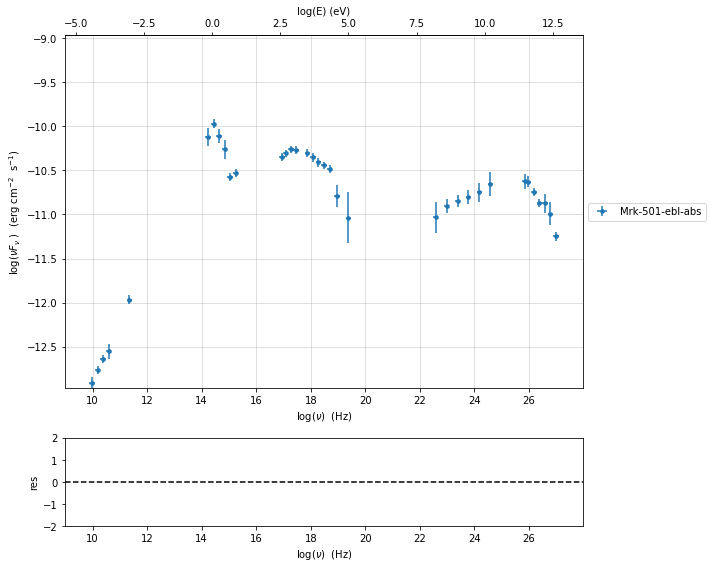

In [4]:
%matplotlib inline
sed_data=ObsData(data_table=data)
sed_data.group_data(bin_width=0.2)

sed_data.add_systematics(0.1,[10.**6,10.**29])
p=sed_data.plot_sed()

In [5]:
sed_data.save('Mrk_501.pkl')

## phenomenological model constraining

### spectral indices


*** evaluating spectral indices for data ***



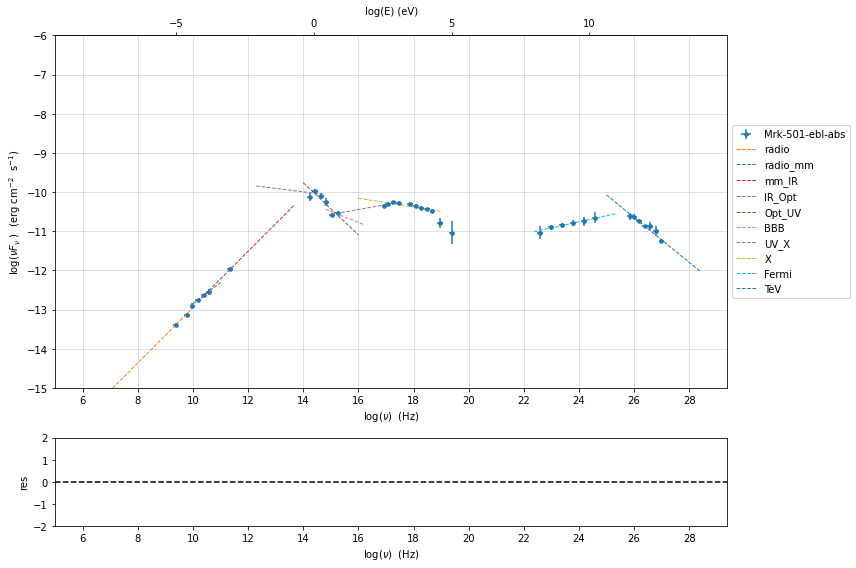

In [6]:
from jetset.sed_shaper import  SEDShape
my_shape=SEDShape(sed_data)
my_shape.eval_indices(minimizer='lsb',silent=True)
p=my_shape.plot_indices()
p.rescale(y_min=-15,y_max=-6)

### sed shaper

In [7]:
mm,best_fit=my_shape.sync_fit(check_host_gal_template=True,
                  Ep_start=None,
                  minimizer='lsb',
                  silent=True,
                  fit_range=[10.,21.])


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [10.0, 21.0]
---> class:  HSP

---> class:  HSP




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-6.411144e-02,-6.411144e-02,7.838965e-03,--,-4.778764e-02,-1.000000e+01,0.000000e+00,False
LogCubic,c,-1.751721e-03,-1.751721e-03,1.127030e-03,--,3.576201e-03,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,1.703747e+01,1.703747e+01,9.437354e-02,--,1.626870e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.030068e+01,-1.030068e+01,1.884114e-02,--,-1.025412e+01,-3.000000e+01,0.000000e+00,False
host_galaxy,nuFnu_p_host,-1.006557e+01,-1.006557e+01,5.462528e-02,--,-1.025412e+01,-1.225412e+01,-8.254123e+00,False
host_galaxy,nu_scale,1.730764e-02,1.730764e-02,3.694887e-03,--,0.000000e+00,-5.000000e-01,5.000000e-01,False


---> sync       nu_p=+1.703747e+01 (err=+9.437354e-02)  nuFnu_p=-1.030068e+01 (err=+1.884114e-02) curv.=-6.411144e-02 (err=+7.838965e-03)




*** Log-Polynomial fitting of the IC component ***
---> fit range: [23.0, 29.0]
---> LogCubic fit




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.565399e-01,-1.565399e-01,2.551779e-02,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-4.351917e-02,-4.351917e-02,2.032066e-02,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,2.529709e+01,2.529709e+01,1.817241e-01,--,2.536916e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.058825e+01,-1.058825e+01,5.046950e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> IC         nu_p=+2.529709e+01 (err=+1.817241e-01)  nuFnu_p=-1.058825e+01 (err=+5.046950e-02) curv.=-1.565399e-01 (err=+2.551779e-02)



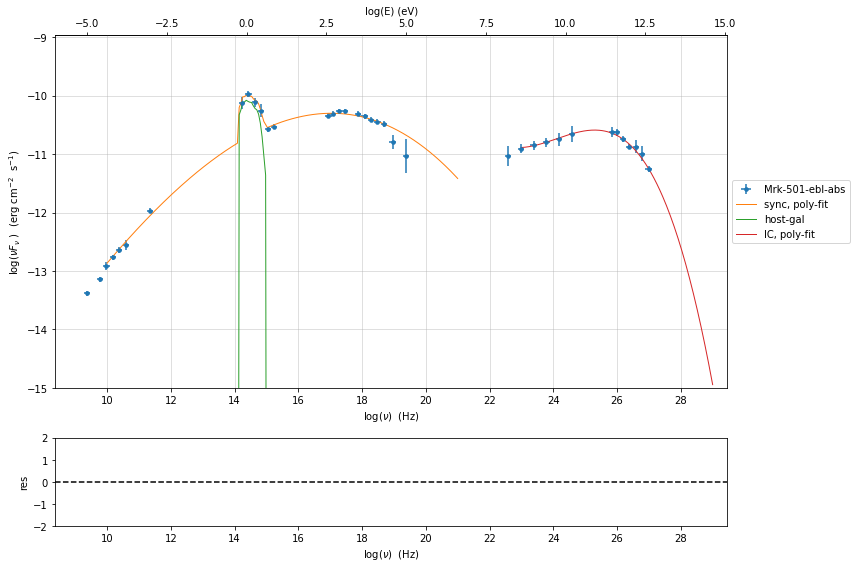

In [8]:
my_shape.IC_fit(fit_range=[23.,29.],minimizer='minuit',silent=True)
p=my_shape.plot_shape_fit()
p.rescale(y_min=-15)

### Model constraining

In this step we are not fitting the model, we are just obtaining the phenomenological `pre_fit` model, that will be fitted in using minuit ore least-square bound, as shown below

In [9]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='lppl',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E12,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet.pkl')


***  constrains parameters from observable ***



model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,1.056955e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.360000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.703917e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,7.087137e+00,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045843e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False


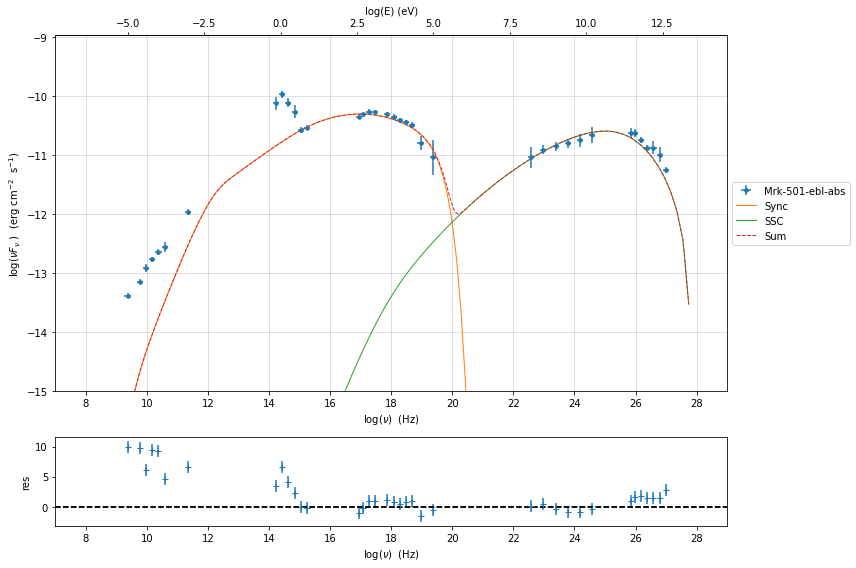

In [10]:
pl=prefit_jet.plot_model(sed_data=sed_data)
pl.add_model_residual_plot(prefit_jet,sed_data)
pl.rescale(y_min=-15,x_min=7,x_max=29)

## Model fitting with Sherpa


In [11]:
from jetset.sherpa_plugin import JetsetSherpaModel


In [12]:
from jetset.template_2Dmodel import EBLAbsorptionTemplate
ebl_franceschini=EBLAbsorptionTemplate.from_name('Franceschini_2008')

In [13]:
from jetset.jet_model import Jet
prefit_jet=Jet.load_model('prefit_jet.pkl')


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.703917e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,2.310708e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,7.087137e+00,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,1.045843e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.248787e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,3.205572e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,1.056955e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,2.500000e+01,1.000000e-04,--,False,False


In [14]:
sherpa_model_jet=JetsetSherpaModel(prefit_jet)
sherpa_model_gal=JetsetSherpaModel(my_shape.host_gal)
sherpa_model_ebl=JetsetSherpaModel(ebl_franceschini)



jetset model name R renamed to  R_sh due to sherpa internal naming convention


In [15]:
sherpa_model=(sherpa_model_jet+sherpa_model_gal)*sherpa_model_ebl

In [16]:
sherpa_model

<BinaryOpModel model instance '((jet_leptonic + host_galaxy) * Franceschini_2008)'>

In [17]:
sherpa_model_ebl.z_cosm  = sherpa_model_jet.z_cosm

In [18]:
sherpa_model

<BinaryOpModel model instance '((jet_leptonic + host_galaxy) * Franceschini_2008)'>

In [19]:
sherpa_model_jet.R_H.freeze()
sherpa_model_jet.z_cosm.freeze()
sherpa_model_gal.nu_scale.freeze()

In [20]:

sherpa_model_jet.beam_obj.min = 5 
sherpa_model_jet.beam_obj.max = 50.

sherpa_model_jet.R_sh.min = 10**15. 
sherpa_model_jet.R_sh.max = 10**17.5

sherpa_model_jet.gmax.min = 1E5 
sherpa_model_jet.gmax.max = 1E7



In [21]:
sherpa_model

<BinaryOpModel model instance '((jet_leptonic + host_galaxy) * Franceschini_2008)'>

In [22]:
from sherpa import data
from sherpa.fit import Fit
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar, NelderMead

In [23]:

sherpa_data=data.Data1D("sed", sed_data.table['nu_data'], sed_data.table['nuFnu_data'], staterror=sed_data.table['dnuFnu_data'])


In [24]:
fitter = Fit(sherpa_data, sherpa_model, stat=Chi2(), method=LevMar())
fit_range=[1e11,1e29]

sherpa_data.notice(fit_range[0], fit_range[1])


In [25]:
results = fitter.fit()

In [26]:
print("fit succeeded", results.succeeded)


fit succeeded True


In [27]:
results

Parameter,Best-fit value,Approximate error
jet_leptonic.gmin,221.318,± 223.032
jet_leptonic.gmax,2.12042e+06,± 0
jet_leptonic.N,9.7309,± 9.52985
jet_leptonic.gamma0_log_parab,6444.37,± 0
jet_leptonic.s,2.20226,± 0.0932377
jet_leptonic.r,0.225421,± 0.0344871
jet_leptonic.R_sh,1.47547e+16,± 0
jet_leptonic.B,0.0123178,± 0.00255532
jet_leptonic.beam_obj,41.9941,± 5.52668
host_galaxy.nuFnu_p_host,-10.0581,± 0.0509935


In [28]:
sherpa_model

<BinaryOpModel model instance '((jet_leptonic + host_galaxy) * Franceschini_2008)'>

In [29]:
from jetset.sherpa_plugin import plot_sherpa_model


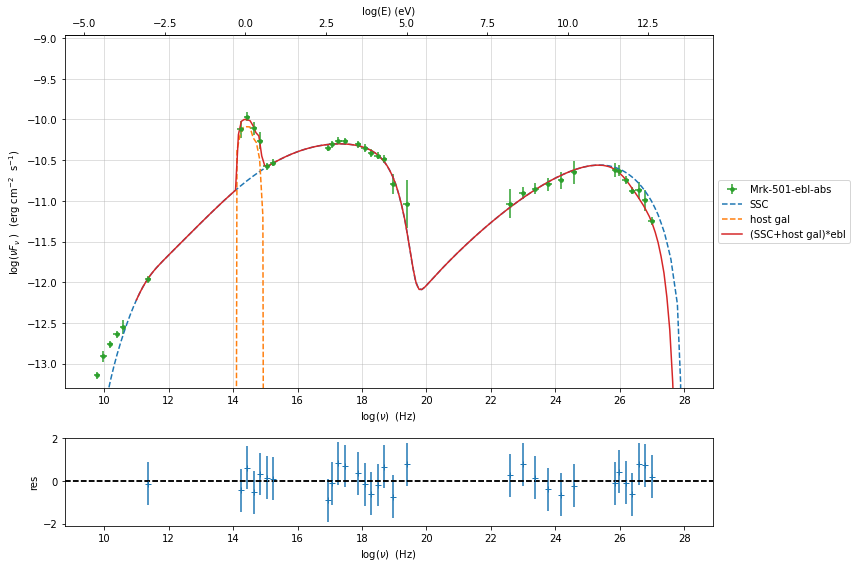

In [30]:
p=plot_sherpa_model(sherpa_model_jet,label='SSC',line_style='--')
p=plot_sherpa_model(sherpa_model_gal,plot_obj=p,label='host gal',line_style='--')
p=plot_sherpa_model(sherpa_model=sherpa_model,plot_obj=p,sed_data=sed_data,fit_range=fit_range,add_res=True,label='(SSC+host gal)*ebl')



You can access all the sherpa fetarues https://sherpa.readthedocs.io/en/latest/fit/index.html

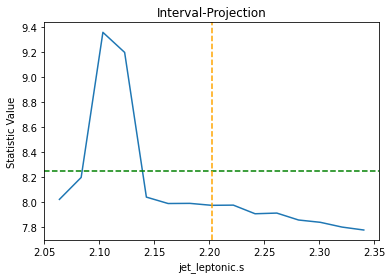

In [31]:
from sherpa.plot import IntervalProjection
iproj = IntervalProjection()
iproj.prepare(fac=5, nloop=15)
iproj.calc(fitter, sherpa_model_jet.s)
iproj.plot()